# Process the Observations data

## Imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.float_format = '{:10,.3f}'.format

### Presence-Absence (PA) surveys

Including around 90 thousand surveys with roughly 10,000 species of the European flora. The presence-absence data (PA) is provided to compensate for the problem of false-absences of PO data and calibrate models to avoid associated biases.

- numerical: 'lon', 'lat', 'geoUncertaintyInM', 'areaInM2', 
- ordinal: 'year'
- categorical: 'region', 'country', 'speciesId', 'surveyId'

In [3]:
pa_train = pd.read_csv('data/GLC24_PA_metadata_train.csv')
pa_test = pd.read_csv('data/GLC24_PA_metadata_test.csv')

In [4]:
pa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483637 entries, 0 to 1483636
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   lon                1483637 non-null  float64
 1   lat                1483637 non-null  float64
 2   year               1483637 non-null  int64  
 3   geoUncertaintyInM  1471141 non-null  float64
 4   areaInM2           1300365 non-null  float64
 5   region             1483637 non-null  object 
 6   country            1483637 non-null  object 
 7   speciesId          1483637 non-null  float64
 8   surveyId           1483637 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 101.9+ MB


#### lon

- Longtitude of area surveyed
- Data appears complete

In [5]:
pa_train.lon.describe()

count   1,483,637.000
mean            9.025
std             4.437
min            -9.018
25%             6.053
50%             9.381
75%            10.419
max            29.154
Name: lon, dtype: float64

In [6]:
pa_train.query('lon == 0') # incase we have nulls entered as 0

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId


#### lat
- Latitude of area surveyed
- Data appears complete

In [7]:
pa_train.lat.describe()

count   1,483,637.000
mean           52.426
std             4.853
min            35.117
25%            48.568
50%            55.153
75%            56.260
max            59.893
Name: lat, dtype: float64

In [8]:
pa_train.query('lat == 0') # incase we have nulls entered as 0

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId


### year
- complete
- possibly change to ordinal

In [9]:
pa_train.year.describe()

count   1,483,637.000
mean        2,018.179
std             1.095
min         2,017.000
25%         2,017.000
50%         2,018.000
75%         2,019.000
max         2,021.000
Name: year, dtype: float64

#### geoUncertaintyInM

- Appears to be a measure of positional uncertainty in the meassurement
- 12496 entries without a value
- possibly just set this to 10 (the most frequent)
- not sure how to use this information

In [10]:
pa_train.geoUncertaintyInM.isna().sum()

12496

In [11]:
pa_train.geoUncertaintyInM.describe()

count   1,471,141.000
mean            7.483
std             6.191
min             0.000
25%             3.000
50%            10.000
75%            10.000
max           100.000
Name: geoUncertaintyInM, dtype: float64

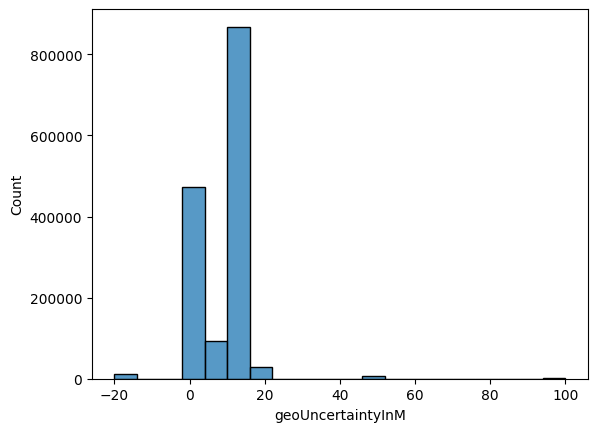

In [12]:
sns.histplot(pa_train.geoUncertaintyInM.fillna(-20), bins=20)
plt.show()

#### areaInM2

- Area of sample or from where sample was taken?
- 51592 have a value set to -inf
- 183272 have no value set

In [13]:
pa_train.query('areaInM2 <= 0')

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
98,12.450,47.012,2018,3.000,-inf,ALPINE,Austria,"9,024.000",489
104,12.450,47.012,2018,3.000,-inf,ALPINE,Austria,"6,643.000",489
105,12.450,47.012,2018,3.000,-inf,ALPINE,Austria,"9,253.000",489
114,12.450,47.012,2018,3.000,-inf,ALPINE,Austria,"1,818.000",489
125,12.450,47.012,2018,3.000,-inf,ALPINE,Austria,"1,818.000",489
...,...,...,...,...,...,...,...,...,...
1482962,4.236,52.074,2017,3.000,-inf,ATLANTIC,Netherlands,"7,817.000",3917861
1482963,4.236,52.074,2017,3.000,-inf,ATLANTIC,Netherlands,"5,704.000",3917861
1482964,4.236,52.074,2017,3.000,-inf,ATLANTIC,Netherlands,"10,514.000",3917861
1482965,4.236,52.074,2017,3.000,-inf,ATLANTIC,Netherlands,"4,397.000",3917861


In [14]:
pa_train.areaInM2.isna().sum()

183272

In [15]:
pa_train.query('areaInM2 > 0').areaInM2.describe()

count   1,248,773.000
mean          122.642
std           214.578
min             0.010
25%            30.000
50%            79.000
75%            79.000
max         8,000.000
Name: areaInM2, dtype: float64

In [16]:
pa_train.query('areaInM2 > 1000')

,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
23771,5.746,50.961,2018,0.000,"4,200.000",ATLANTIC,Netherlands,"2,704.000",65729
23772,5.746,50.961,2018,0.000,"4,200.000",ATLANTIC,Netherlands,"11,071.000",65729
23773,5.746,50.961,2018,0.000,"4,200.000",ATLANTIC,Netherlands,"4,493.000",65729
23774,5.746,50.961,2018,0.000,"4,200.000",ATLANTIC,Netherlands,"2,684.000",65729
23775,5.746,50.961,2018,0.000,"4,200.000",ATLANTIC,Netherlands,"3,111.000",65729
...,...,...,...,...,...,...,...,...,...
1402467,4.931,51.207,2020,0.000,"1,100.000",ATLANTIC,Belgium,"3,738.000",3714019
1402468,4.931,51.207,2020,0.000,"1,100.000",ATLANTIC,Belgium,"2,807.000",3714019
1402469,4.931,51.207,2020,0.000,"1,100.000",ATLANTIC,Belgium,"4,898.000",3714019
1402470,4.931,51.207,2020,0.000,"1,100.000",ATLANTIC,Belgium,"6,900.000",3714019


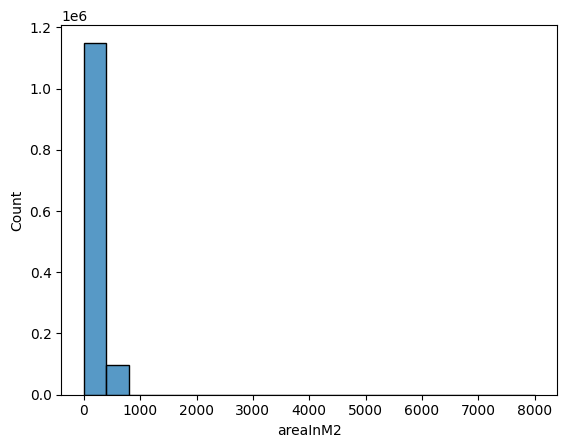

In [17]:
sns.histplot(pa_train.query('areaInM2 > 0').areaInM2, bins=20)
plt.show()

#### region

- complete
- covers 8 regions
- very skewed

In [18]:
pa_train.region.value_counts()

region
CONTINENTAL      773578
ATLANTIC         506288
MEDITERRANEAN    123112
ALPINE            62457
BOREAL            11723
PANNONIAN          5985
STEPPIC             460
BLACK SEA            34
Name: count, dtype: int64

In [19]:
pa_train.region.nunique()

8

#### country

- complete
- covers 29 counntries
- coverage is very skewed

In [20]:
pa_train.country.unique()

array(['France', 'Denmark', 'Netherlands', 'Austria', 'Germany', 'Spain',
       'Poland', 'Belgium', 'Czech Republic', 'Italy', 'Serbia',
       'Montenegro', 'Switzerland', 'Slovakia', 'Romania', 'Slovenia',
       'Latvia', 'Croatia', 'Hungary', 'Bulgaria', 'Greece', 'Ireland',
       'Bosnia and Herzegovina', 'Andorra', 'Monaco',
       'The former Yugoslav Republic of Macedonia', 'Portugal', 'Norway',
       'Luxembourg'], dtype=object)

In [21]:
pa_train.country.value_counts()

country
Denmark                                      791993
France                                       247739
Netherlands                                  179457
Italy                                         46625
Austria                                       43821
Belgium                                       31620
Germany                                       24701
Czech Republic                                24481
Montenegro                                    20652
Poland                                        13697
Latvia                                        11723
Spain                                         11574
Romania                                        8114
Switzerland                                    6466
Slovakia                                       4850
Croatia                                        4837
Bulgaria                                       2738
Greece                                         2268
Serbia                                         1803
Bosn

In [22]:
pa_train.query('country == "Norway"').speciesId.value_counts()

speciesId
5,285.000    3
4,397.000    3
6,643.000    3
  623.000    2
6,746.000    2
2,949.000    2
4,541.000    2
9,890.000    1
5,901.000    1
3,293.000    1
8,221.000    1
6,208.000    1
2,292.000    1
4,748.000    1
1,162.000    1
3,151.000    1
  462.000    1
6,626.000    1
3,352.000    1
  171.000    1
5,980.000    1
5,420.000    1
9,376.000    1
5,677.000    1
3,963.000    1
2,248.000    1
Name: count, dtype: int64

In [23]:
pa_train.query('region == "BLACK SEA"').speciesId.value_counts()

speciesId
10,239.000    8
 2,471.000    4
10,142.000    3
 6,491.000    3
10,731.000    2
 9,754.000    2
 5,420.000    2
 4,027.000    1
 2,684.000    1
   734.000    1
 8,635.000    1
 9,940.000    1
 8,924.000    1
     3.000    1
 5,242.000    1
10,632.000    1
 5,090.000    1
Name: count, dtype: int64

In [24]:
pa_train.country.nunique()

29

In [25]:
pa_train.surveyId.nunique()

88987

In [26]:
pa_train.speciesId.nunique()

5016

In [27]:
pa_train.speciesId.value_counts()

speciesId
   540.000    21489
 4,397.000    19791
   254.000    18117
 4,499.000    15270
10,317.000    14570
              ...  
 8,312.000        1
 8,381.000        1
 7,572.000        1
 9,807.000        1
 8,119.000        1
Name: count, Length: 5016, dtype: int64

### Fixes

In [28]:
countries = list(pa_train.country.unique())
regions = list(pa_train.region.unique())
species = list(pa_train.speciesId.unique())
surveys = list(pa_train.surveyId.unique())

In [29]:
years = list(pa_train.year.unique())
years.sort()

In [30]:
numerical_cols = ['lon', 'lat']#, 'geoUncertaintyInM', 'areaInM2']
ordinal_cols = {
    'year': years
}
categorical_cols = {
    'region': regions,
    'country': countries,
    # 'speciesId': species,
    # 'surveyId': surveys
}

In [31]:
pa_train = pa_train.drop(columns=['geoUncertaintyInM', 'areaInM2'])
pa_test = pa_test.drop(columns=['geoUncertaintyInM', 'areaInM2'])

In [32]:
# num_pipeline = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

In [33]:
# ord_pipeline = Pipeline(steps=[
#     ('scaler', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

In [34]:
# ohe_pipeline = Pipeline(steps=[
#     ('encoder', OneHotEncoder())
# ])

In [35]:
# list(ordinal_cols)

In [36]:
# col_trans = ColumnTransformer(transformers=[
#     ('num', num_pipeline, numerical_cols),
#     ('ord', ord_pipeline, list(ordinal_cols)),
#     ('ohe', ohe_pipeline, list(categorical_cols))
#     ],
#     remainder='passthrough',
#     n_jobs=-1
# )

In [37]:
# pipeline = Pipeline(steps=[
#     ('preprocessor', col_trans),
# ])

In [57]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), list(categorical_cols)),
    remainder='passthrough')

transformed = transformer.fit_transform(pa_train)
transformer.get_feature_names_out().shape



(42,)

In [47]:
transformed.shape

(1483637, 42)

In [58]:
sk.set_config(enable_metadata_routing=True)

pa_train_copy = pa_train.copy()
print(pa_train_copy.shape)
transformed = transformer.fit_transform(pa_train_copy)
print(transformed.shape)

(1483637, 7)
(1483637, 42)


In [59]:
transformed_df = pd.DataFrame(
    transformer.fit_transform(pa_train),
    columns=transformer.get_feature_names_out()
)

In [44]:
transformed_df.shape

(1483637, 1)

In [60]:
transformed_df.head()

,onehotencoder__region_ALPINE,onehotencoder__region_ATLANTIC,onehotencoder__region_BLACK SEA,onehotencoder__region_BOREAL,onehotencoder__region_CONTINENTAL,onehotencoder__region_MEDITERRANEAN,onehotencoder__region_PANNONIAN,onehotencoder__region_STEPPIC,onehotencoder__country_Andorra,onehotencoder__country_Austria,...,onehotencoder__country_Slovakia,onehotencoder__country_Slovenia,onehotencoder__country_Spain,onehotencoder__country_Switzerland,onehotencoder__country_The former Yugoslav Republic of Macedonia,remainder__lon,remainder__lat,remainder__year,remainder__speciesId,remainder__surveyId
0,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.099,43.135,"2,021.000","6,874.000",212.000
1,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.099,43.135,"2,021.000",476.000,212.000
2,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.099,43.135,"2,021.000","11,157.000",212.000
3,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.099,43.135,"2,021.000","8,784.000",212.000
4,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,3.099,43.135,"2,021.000","4,530.000",212.000


In [62]:
X = transformed_df.drop(columns=['remainder__speciesId', 'remainder__surveyId'])
y = pa_train.speciesId

In [ ]:
# X_preprocessed = pipeline.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [66]:
dtc = DecisionTreeClassifier(random_state=113)

In [71]:
X_train.shape

(1186909, 40)

In [76]:
param_grid = {
    'min_samples_split': [5, 10, 15],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [77]:
CV_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))

In [81]:
CV_dtc.fit(X_train, y_train)
# CV_dtc.fit(X_train.iloc[:1000], y_train.iloc[:1000])
# dtc.fit(X_train.iloc[:1000], y_train.iloc[:1000])

/home/startung/code/ml-geolife/.venv/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=113),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15]})

In [82]:
print(f'Best params: {CV_dtc.best_params_}')
print(f'Best score: {CV_dtc.best_score_}')

Best params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.03203615460699405


### Presence-Only (PO) occurrences

Combines around five million observations from numerous datasets gathered from the Global Biodiversity Information Facility (GBIF, www.gbif.org). This data constitutes the larger piece of the training data and covers all countries of our study area, but it has been sampled opportunistically (without standardized sampling protocol), leading to various sampling biases. The local absence of a species among PO data doesn't mean it is truly absent. An observer might not have reported it because it was difficult to "see" it at this time of the year, to identify it as not a monitoring target, or just unattractive.

In [83]:
po_train = pd.read_csv('data/GLC24_P0_metadata_train.csv')